In [ ]:
#Set Up for Packages that I will need Later
!pip install plotly==4.14.3
!pip install plotly-geo
!pip install geopandas
!pip install pyshp
!pip install shapely

import pandas as pd
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Importing the necessary Datasets + Description of what is in each data set

#This data set has population information and other demographic data for each county in the US
US_countyinfo = df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')

#This dataset includes the vaccinations by race and by county in PA
pa_racedata = pd.read_csv('https://raw.githubusercontent.com/desmondg19/CLPSProject2/main/COVID-19_Vaccinations_by_Race_Current_County_Health%20(3).csv')
#Note for next line - there is an error in the spelling of one of the pa_racedata column which next line fixes
pa_racedata.rename(columns={'Partially Covered  Unknown': 'Partially Covered Unknown'}, inplace=True)

For this part of the project, we were interested in studying how vaccination rates varied by race both in the US broadly, but most specifically in Pennsylvania, because PA had very detailed information about vaccination by various demographic variables, including race. 

To start off, we generated the following choropleth maps that show vaccination inequity across the United States. The top graph below shows the ratio of the percentage of white vs Black residents of each state that were vaccinated. The second graph shows similar data for Hispanic residents and the third graph shows that data for Asian residents. Each graph is labelled with a title below! The colorbar represents the ratios as explained above. 


In [ ]:
#Choropleth for the US
#This dataset has information about each state that was used to generate the maps
state_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
#This dataset has the values of the vaccination ratios explained above
state_race_data = pd.read_csv('https://raw.githubusercontent.com/desmondg19/CLPSProject2/main/Modified_PercentTotalPopulationReceivedVaccineRace_Ethnicity.csv')

#Merging the two datasets + replacing states without data with zeros
state_df.reset_index(drop=True, inplace=True)
state_race_data.reset_index(drop=True, inplace=True)
state_data_wcodes = pd.merge(state_df[['code', 'state']], state_race_data, left_on='state', right_on = 'Location')
state_data_wcodes['White to Black Ratio'] = state_data_wcodes['White to Black Ratio'].str.replace('NR', '0')
state_data_wcodes['White to Hispanic Ratio'] = state_data_wcodes['White to Hispanic Ratio'].str.replace('NR', '0')
state_data_wcodes['White to Asian Ratio'] = state_data_wcodes['White to Asian Ratio'].str.replace('NR', '0')

#Generating the choropleth graphs
white_to_black_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Black Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_black_fig.update_layout(
    title_text = 'White to Black Vaccination Ratio',
    geo_scope='usa')
white_to_hispanic_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Hispanic Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_hispanic_fig.update_layout(
    title_text = 'White to Hispanic Vaccination Ratio',
    geo_scope='usa')
white_to_asians_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Asian Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_asians_fig.update_layout(
    title_text = 'White to Asian Vaccination Ratio',
    geo_scope='usa')

white_to_black_fig.show()
white_to_hispanic_fig.show()
white_to_asians_fig.show()

As can be seen from these three figures, PA is one of the most unequal states in the country when it comes to vaccine equity between white and non-white residents. First, for the ratio of white to Black vaccination rates, PA is the second most unequal state with a ratio of 3.4 (second only to Iowa with a ratio of 3.5). Second, for the ratio of white to Hispanic vaccination rates, PA is tied for first as the highest ratio (along with Georgia), with a ratio of 4.7. And finally, for the ratio of white to Asian vaccination rates, PA is by far the most unequal in vaccination, with a ratio of 20.8. The next highest state is Iowa, with a ratio of 2.4. 

From this data, we were interested in learning more about how vaccination varies by race/ethnicity in PA. 

This next set of graphs compares the vaccinations by race for the entire state of PA. The data is plotted as a series of bar charts. The first shows the differences in the percentages of people partially vaccinated by race. The second shows the differences in percentages of people fully vaccinated by race. The last shows the differences in the percentages of people either partially or fully vaccinated by race. 

In [ ]:
#Reading in vaccinations by race for all of PA
pa_racedata_statewide = pd.read_csv('https://raw.githubusercontent.com/desmondg19/CLPSProject2/main/COVID-19_Vaccinations_by_Race_Current_Statewide_Health%20(1).csv')

#importing racial breakdown of PA State
pa_population_2010 = 12702379
pa_racebreakdown = pd.read_html('https://en.wikipedia.org/wiki/Pennsylvania', match = 'Pennsylvania Racial Breakdown of Population')[0]
#source for PI and Hawaiian population used below: https://www.census.gov/quickfacts/fact/map/philadelphiacountypennsylvania,PA/RHI525219#qf-headnote-a

#Cleaning the data - changing column names, converting to float, making races match up between data sets
pa_racebreakdown.rename(columns={'2010[83]': '2010'}, inplace=True)
pa_racebreakdown.rename(columns={'Racial composition': 'Race'}, inplace=True)
pa_racebreakdown['2010'] = pa_racebreakdown['2010'].str.replace('%', '').str.replace('–', '0.1')
pa_racebreakdown['2010'] = pa_racebreakdown['2010'].astype(float)
pa_racebreakdown['Race'] = pa_racebreakdown['Race'].str.replace('Black', 'African American')
pa_racebreakdown['Race'] = pa_racebreakdown['Race'].str.replace('Native Hawaiian andother Pacific Islander', 'Pacific Islander')
pa_racebreakdown['Race'] = pa_racebreakdown['Race'].str.replace('Native','Native American')

#Combining the multiple and other rows to be consistent with COVID race data
multiple_otherrow = {'Race': 'Multiple/Other', '1990[81]': 1.0, '2000[82]': 2.7, '2010': 2.4+1.9}
pa_racebreakdown = pa_racebreakdown.append(multiple_otherrow, ignore_index = True)
pa_racebreakdown = pa_racebreakdown.drop(5,axis=0)
pa_racebreakdown = pa_racebreakdown.drop(6,axis=0)

#Merging the two datasets
pa_racebreakdown.reset_index(drop=True, inplace=True)
pa_racedata_statewide.reset_index(drop=True, inplace=True)
pa_racedata_statewide = pd.merge(pa_racedata_statewide, pa_racebreakdown, on = 'Race')

#Dropping uneeded columns and converting population to number instead of percent
pa_racedata_statewide = pa_racedata_statewide.drop('1990[81]',axis=1).drop('2000[82]', axis=1)
pa_racedata_statewide['2010'] = pa_racedata_statewide['2010'] * pa_population_2010/100
pa_racedata_statewide

#Adding new columns with percent vaccinated by race
pa_racedata_statewide['Partially or Fully Covered'] = pa_racedata_statewide['Partially Covered'] + pa_racedata_statewide['Fully Covered']
pa_racedata_statewide['Percent Partially Covered'] = pa_racedata_statewide['Partially Covered']/pa_racedata_statewide['2010'] * 100
pa_racedata_statewide['Percent Fully Covered'] = pa_racedata_statewide['Fully Covered']/pa_racedata_statewide['2010'] * 100
pa_racedata_statewide['Percent Partially or Fully Covered'] = pa_racedata_statewide['Partially or Fully Covered']/pa_racedata_statewide['2010'] * 100
pa_racedata_statewide

#Generating Bar Charts by Race
partorfully_byrace_pa = pa_racedata_statewide.plot(x = 'Race', y = "Percent Partially or Fully Covered",
                        kind = 'bar', fontsize = 10, figsize = (12.5, 5), color = 'cornflowerblue',
                        xlabel = 'Race/Ethnicity', ylabel = 'Percent Partially or Fully Vaccinated', 
                        title = 'Percent Partially or Fully Vaccinated by Race')
part_byrace_pa = pa_racedata_statewide.plot(x = 'Race', y = "Percent Partially Covered",
                        kind = 'bar', fontsize = 10, figsize = (12.5, 5), color = 'cornflowerblue',
                        xlabel = 'Race/Ethnicity', ylabel = 'Percent Partially Vaccinated', 
                        title = 'Percent Partially Vaccinated by Race')
full_byrace_pa = pa_racedata_statewide.plot(x = 'Race', y = "Percent Fully Covered",
                                            kind = 'bar', fontsize = 10, figsize = (12.5, 5), color = 'cornflowerblue',
                                            xlabel = 'Race/Ethnicity', ylabel = 'Percent Fully Vaccinated', 
                                            title = 'Percent Fully Vaccinated by Race')

From the data above, we can start to see a pattern emerge. Regardless of whether we're looking at partial and full, just partial, or just full, the rates of vaccination are highest among the Multiple/Other category and second highest among Pacific Islander. However, given the very small fraction those groups make up as a percentage of the overall population, it is hard to reliably make a conclusion about those groups. 

Additionally, we can see that white residents of PA are getting vaccinated at a higher rate than African American or Asian residents. 

One issue of note - all COVID vaccination databases lumped "Hispanic" as a race. In contrast, however, the population-wide census data considered Hispanic as an ethnicity, and thus, it was not possible to add a bar corresponding to Hispanic vaccinations at this stage of the analysis.

Now, we wanted to look at the racial breakdown of vaccination levels at the county by county level. The rest of the data in this section of the project is based on county-by-county vaccination levels. This next cell is all the data processing required and the comments break down what we were doing at each step. Afterwards, we generated more choropleths that are explained below. 

We chose to do analysis for white vs non-white vaccinations only. First, the reason for this is the quality of the information about each racial group varied and there were a lot of spots where the number of vaccinations was zero. Second, it was challenging to find a dataset that that had race/ethnicity data defined the same way that the COVID data did, since Hispanic was considered an ethnicity. We were, in contrast, able to find data about Non-Hispanic Whites vs other races/ethnicities, which allowed us to account for the vaccination rates of Hispanic residents. 

In [68]:
#Filling all the blank spots with zero
pa_racedata.fillna(0, inplace = True)

#Made two new columns with sums of vaccinations for all non-white populations in PA and all people
pa_racedata['Partially Covered Non-White'] = pa_racedata['Partially Covered African American'] + pa_racedata['Partially Covered Asian'] + pa_racedata['Partially Covered Native American'] + pa_racedata['Partially Covered Pacific Islander'] 
pa_racedata['Partially Covered'] = pa_racedata['Partially Covered Non-White'] + pa_racedata['Partially Covered Unknown'] + pa_racedata['Partially Covered White'] + pa_racedata['Partially Covered Multiple Other']
pa_racedata['Fully Covered Non-White'] = pa_racedata['Fully Covered African American'] + pa_racedata['Fully Covered Asian'] + pa_racedata['Fully Covered Native American'] + pa_racedata['Fully Covered Pacific Islander']
pa_racedata['Fully Covered'] = pa_racedata['Fully Covered Non-White'] + pa_racedata['Fully Covered Unknown'] + pa_racedata['Fully Covered White'] + pa_racedata['Fully Covered Multiple Other']
pa_racedata['Partially or Fully Covered'] = pa_racedata['Fully Covered'] + pa_racedata['Partially Covered']

#Filtered the county info table to PA only and changed the value of county column so it matched racedata
pa_countyinfo['CTYNAME'] = pa_countyinfo['CTYNAME'].str.replace(' County','', regex=True)

#Dropped the row that had data about out of state vaccinations
pa_race_instate = pa_racedata.drop(67,axis=0)

#Renamed the county name columns to be the same in the two df's so I could merge them
pa_countyinfo.rename(columns={'CTYNAME': 'County Name'}, inplace=True)
print(pa_countyinfo.columns.values[2] == 'County Name')

#Merging the Data
pa_countyinfo.reset_index(drop=True, inplace=True)
pa_race_instate.reset_index(drop=True, inplace=True)
pa_race_covid = pd.merge(pa_race_instate, pa_countyinfo, on = 'County Name')

#Calculating the Percent of White/Non-White People Vaccinated and Generating New Columns
pa_race_covid['Percent Partially Covered Non-White'] = pa_race_covid['Partially Covered Non-White']/pa_race_covid['Not_NHWhite_Alone'] * 100
pa_race_covid['Percent Fully Covered Non-White'] = pa_race_covid['Fully Covered Non-White']/pa_race_covid['Not_NHWhite_Alone'] * 100
pa_race_covid['Percent Covered Non-White'] = pa_race_covid['Percent Partially Covered Non-White'] + pa_race_covid['Percent Fully Covered Non-White']


pa_race_covid['Percent Partially Covered White'] = pa_race_covid['Partially Covered White']/pa_race_covid['NHWhite_Alone'] * 100
pa_race_covid['Percent Fully Covered White'] = pa_race_covid['Fully Covered White']/pa_race_covid['NHWhite_Alone'] * 100
pa_race_covid['Percent Covered White'] = pa_race_covid['Percent Partially Covered White'] + pa_race_covid['Percent Fully Covered White']

pa_race_covid['Percent Partially Covered'] = pa_race_covid['Partially Covered']/pa_race_covid['TOT_POP'] * 100
pa_race_covid['Percent Fully Covered'] = pa_race_covid['Fully Covered']/pa_race_covid['TOT_POP'] * 100
pa_race_covid['Percent Partially or Fully Covered'] = pa_race_covid['Partially or Fully Covered']/pa_race_covid['TOT_POP'] * 100

True


Now, we generated 6 different choropleth maps. These choropleth maps show data at a county-by-county basis, rather than the state-by-state graphs that we saw before. 

The first set of graphs shows the rates of partial vaccination by county, first for non-white residents, then for white residents, and then for all residents (as there was a significant fraction of counties where most people fell into the unknown race category).

The second set of graphs show rates of full vaccination by county, first for non-white residents, then for white residents, and then for all residents.

In [ ]:
#Vaccination Choropleth Graphs - non-white, white, and all partial/full vaccination
partvac_NW = pa_race_covid['Percent Partially Covered Non-White'].tolist()
fullvac_NW = pa_race_covid['Percent Fully Covered Non-White'].tolist()
partvac_W = pa_race_covid['Percent Partially Covered White'].tolist()
fullvac_W = pa_race_covid['Percent Fully Covered White'].tolist()
partvac = pa_race_covid['Percent Partially Covered'].tolist()
fullvac = pa_race_covid['Percent Fully Covered'].tolist()

pa_fips = pa_race_covid['FIPS'].tolist()

vaccine_endpts = list(np.mgrid[min(fullvac_NW):max(partvac):5j])
blues = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#57a0ce", "#3082be", 
         "#1361a9","#0b4083"]

partvac_NW_fig = ff.create_choropleth(pa_fips, partvac_NW, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Non-White Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Non-White Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_NW_fig = ff.create_choropleth(pa_fips, fullvac_NW, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts, 
                           plot_bgcolor='rgb(229,229,229)', simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Non-White Full Vaccination Percentage',
                           paper_bgcolor='rgb(229,229,229)', 
                           legend_title='Non-White Full Vaccination by County',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_W_fig = ff.create_choropleth(pa_fips, partvac_W, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)', simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'White Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='White Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_W_fig = ff.create_choropleth(pa_fips, fullvac_W, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts, simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'White Full Vaccination by County',
                           plot_bgcolor='rgb(229,229,229)',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='White Full Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_fig = ff.create_choropleth(pa_fips, partvac, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts, 
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)', 
                           legend_title='Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_fig = ff.create_choropleth(pa_fips, fullvac, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts, 
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Full Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Full Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})

#Set 1 of Graphs as explained above
partvac_NW_fig.show()
partvac_W_fig.show()
partvac_fig.show()

#Set 2 of Graphs as explained above
fullvac_NW_fig.show()
fullvac_W_fig.show()
fullvac_fig.show()

Pretty quickly, just based on the colors of each map, we can see there is a clear difference between the white and non-white vaccination percentages and the non-white and overall vaccination percentages (there is a much smaller visual difference that can be seen between the white and overall vaccination percentages). This holds for both partial and full vaccination data. 

At this point, since we didn't see a clear difference in the patterns for partial and full vaccination rates, our analysis shifted to focusing on the combined partial and full vaccination rates for the remainder of the analysis by race. 

We wanted to look at this data in a more quantiative way, so we generated a few additional types of figures below. The first is a stacked barplot by county so we can see the percent vaccinated by county and the racial breakdown for each county. The second figure is a grouped barplot showing the percent covered by race per county, with the white and non-white bars grouped next to each other. The third figure is a scatterplot showing the percent covered white vs non-white, where each dot is a county. The last set of graphs show histograms showing the frequencies of various ranges of percent vaccinated by race (one graph for white residents and one for non-white residents).

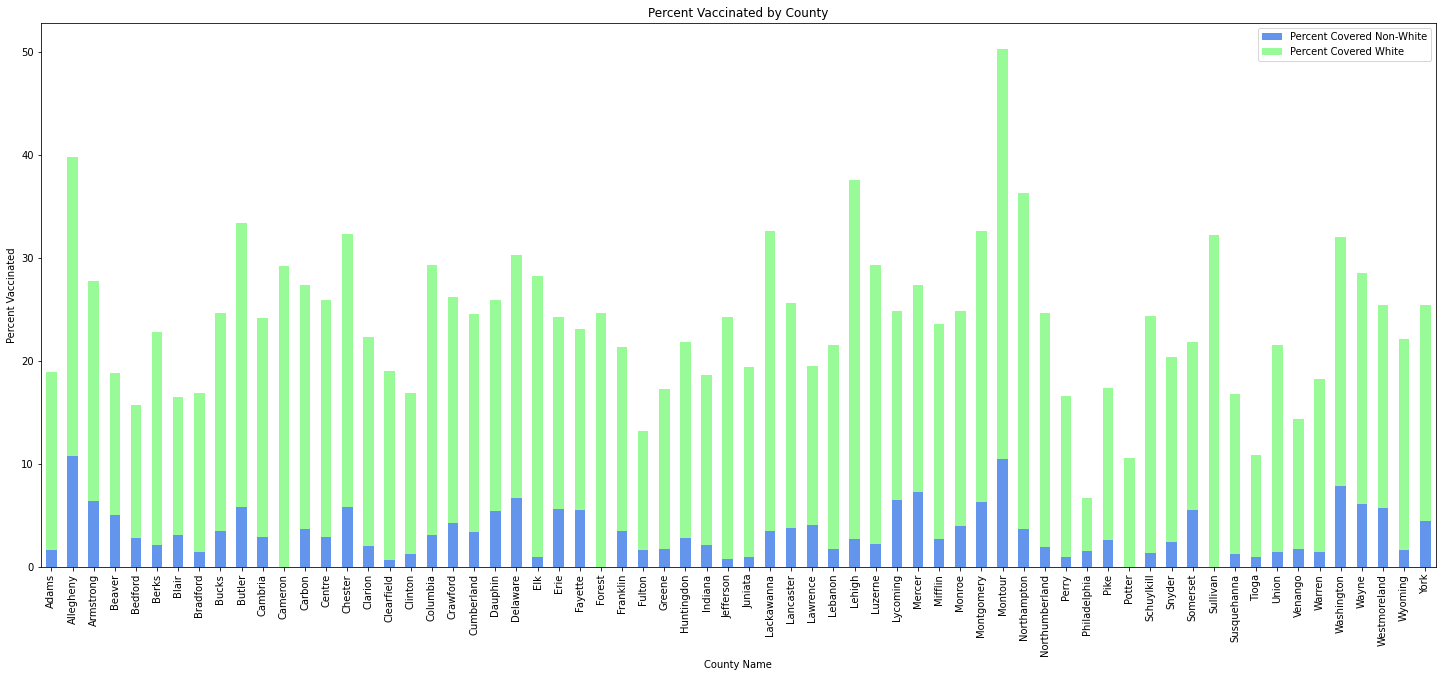

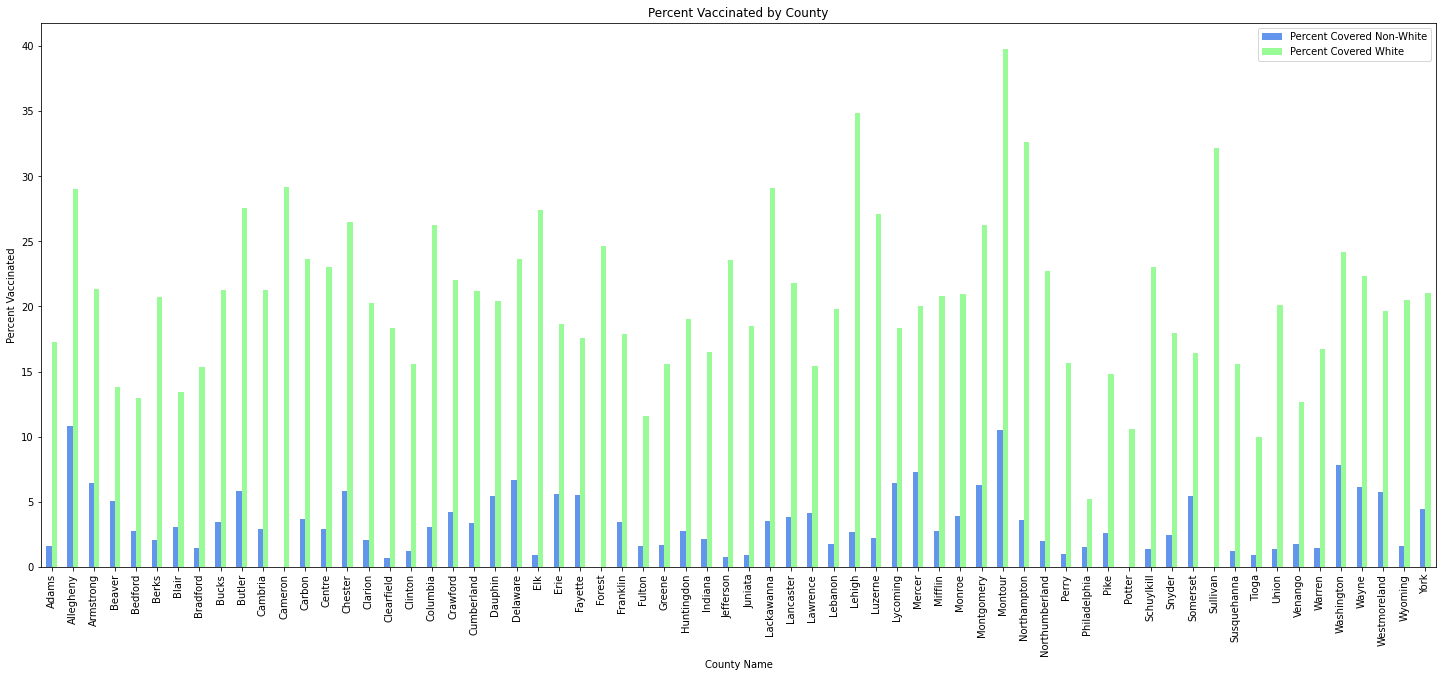

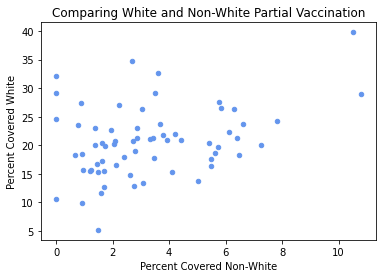

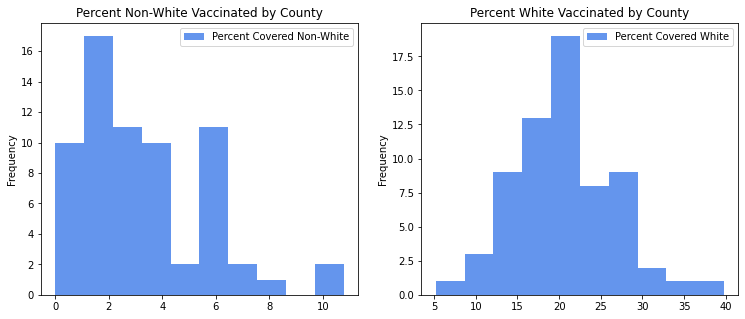

In [86]:
#Vaccination Rates Stacked Barplot by County
pa_race_covid.plot(x = 'County Name', y = ["Percent Covered Non-White", 
                                                "Percent Covered White"], 
                   kind = 'bar', stacked = True, fontsize = 10, figsize = (25, 10),
                   xlabel = 'County Name', ylabel = 'Percent Vaccinated',
                   title = 'Percent Vaccinated by County',
                   color = ['cornflowerblue', 'palegreen'])

#Vaccination Rates Grouped Barplot by County
pa_race_covid.plot(x = 'County Name', y = ["Percent Covered Non-White",
                                           "Percent Covered White"], 
                   kind = 'bar', fontsize = 10, figsize = (25, 10),
                   xlabel = 'County Name', ylabel = 'Percent Vaccinated',
                   title = 'Percent Vaccinated by County', 
                   color = ['cornflowerblue', 'palegreen'])

#Vaccination Scatterplots - White vs Non-White Vaccination Rates
pa_race_covid.plot.scatter('Percent Covered Non-White', 'Percent Covered White',
                        xlabel = 'Percent Covered Non-White', 
                        ylabel = 'Percent Covered White', color = 'cornflowerblue',
                        title = 'Comparing White and Non-White Partial Vaccination')

#Vaccination Histograms - White vs Non-White Vaccination Rates
fig, axes = plt.subplots(nrows=1, ncols = 2)

pa_race_covid.plot(x = 'County Name', y = "Percent Covered Non-White",
                   kind = 'hist', xlabel = 'Percent Covered Non-White',
                   ylabel = 'Frequency', color = 'cornflowerblue',
                   title = 'Percent Non-White Vaccinated by County', 
                   ax = axes[0], figsize = (12.5, 5))
pa_race_covid.plot(x = 'County Name', y = "Percent Covered White",
                   kind = 'hist', xlabel = 'Percent Covered White',
                   ylabel = 'Frequency', color = 'cornflowerblue',
                   title = 'Percent White Vaccinated by County',
                   ax = axes[1], figsize = (12.5, 5))

From the first two graphs, we can see that every county has more white residents vaccinated as a percentage of the white population in the county than non-white residents. This is consistent with our data studying the US as a whole, PA specifically, and from the choropleth maps that we saw above. 

As for the scatterplot, **FILL THIS PART IN ONCE THERE IS A LINE OF BEST FIT ADDED TO THE GRAPH AS IT'S HARD TO DO ANALYSIS OTHERWISE**

From the two histograms, we can see that there is a visual difference in the peak, representing the most common interval by percent of each group (white vs non-white that is vaccinated). It's also worth noting that the scale is different! The peak for non-white residents is about 1-2 percent, while for white residents, it is closer to the range of 17.5-22.5%. Thus, there is a clear difference in the rates of vaccination by race. 

This analysis could be improved if we had better data breaking down vaccinations by race/ethnicity, if ethnicity was considered separately from race, and if the number of unknowns was a smaller percentage of total vaccinations by county. However, from the data analysis above, there does seem to be a difference in vaccination rates by white vs non-white residents of PA. 

Now, we wanted to move on to studying how other variables at the county level influenced vaccination rates. First, we studied how income was correlated with vaccination rates (partial, full, and both rates). The graphs we generated are explained below.  

Text(0, 0.5, 'Median Household Income ($)')

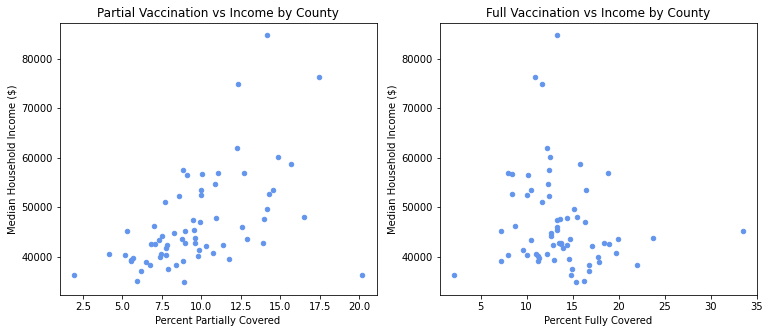

In [94]:
#Adding income related data from an HTML table
pa_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_Pennsylvania_counties_by_per_capita_income')
pa_income = pa_tables[1]
pa_income.rename(columns={'County': 'County Name'}, inplace=True)

#Merging data with COVID data by county
pa_income.reset_index(drop=True, inplace=True)
pa_race_covid.reset_index(drop=True, inplace=True)
pa_income_covid = pd.merge(pa_race_covid, pa_income, on = 'County Name')
pa_income_covid['Medianhouseholdincome'] = pa_income_covid['Medianhouseholdincome'].str.replace('$', '').str.replace(',', '')
pa_income_covid['Medianhouseholdincome'] = pa_income_covid['Medianhouseholdincome'].astype(int)

#Income Choropleth
incomes = pa_income_covid['Medianhouseholdincome'].tolist()
income_endpts = list(np.mgrid[min(incomes):max(incomes):5j])
incomes_fig = ff.create_choropleth(pa_fips, incomes, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=income_endpts,
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Median Household Income by County',
                           legend_title='Median Household Income ($)',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_fig.show()
fullvac_fig.show()
incomes_fig.show()

#Income scatterplots
fig, axes = plt.subplots(nrows=1, ncols = 2)

income_part = pa_income_covid.plot.scatter(x = 'Percent Partially Covered',  y ='Medianhouseholdincome', 
                             xlabel = 'Percent Partially Covered',
                             title = 'Partial Vaccination vs Income by County', 
                             ax = axes[0], color = 'cornflowerblue', figsize = (12.5, 5))
income_part.set_ylabel('Median Household Income ($)')
income_full = pa_income_covid.plot.scatter(x = 'Percent Fully Covered', y ='Medianhouseholdincome',
                             xlabel = 'Percent Fully Covered',
                             title = 'Full Vaccination vs Income by County',
                             ax = axes[1], color = 'cornflowerblue', figsize = (12.5, 5))
income_full.set_ylabel('Median Household Income ($)')

The first graph is the same choropleth we saw above for the partial vaccination rates in the whole county, and the second graph is for the full vaccination rates in the whole county. The third graph represents the Median Household income for each county. In contrast to the data from before, it is much more challenging to visually see a relationship between income and vaccination. 

Next, we generated a scatter plot, where the x axis is the percent partially covered on the left and the percent fully covered on the right. On both graphs, the y-axis is the median household income. **Finish this once the lines of best fit have been added bc it's hard to add to them**

We can think of a few potential explanations of this. First, people fully vaccinated by the time we started this anlysis (early April) are the healthcare workers and other high-risk occupations as well as the elderly. Many high-risk occuptations/frontline worker positions do not have high salaries, although some certainly do. Because of that, there might not be as clear of a trend. Second, the elderly on average have lower median household incomes, and as a consequence, the higher proportion of the elderly that were vaccinated early might result in the lack of a relationship between the percent covered and median household income. 

Next, we wanted to see how vaccination rates were related to the percentage of the county that voted for Trump. The graphs are explained below. 

Text(0, 0.5, 'Percent Trump Votes')

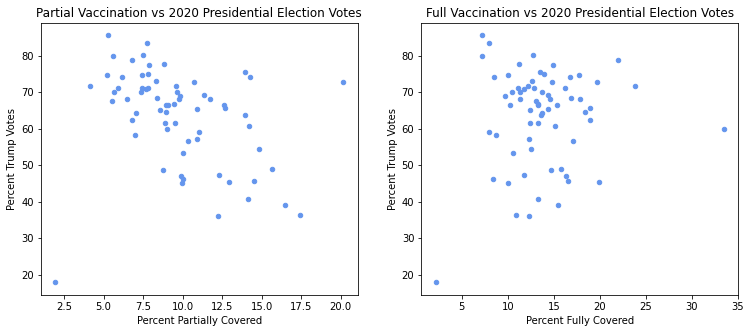

In [96]:
#Adding Election Related data from HTML table
pa_elections = pd.read_html('https://en.wikipedia.org/wiki/2020_United_States_presidential_election_in_Pennsylvania')
pa_pres_elections = pa_elections[32]

#Table was a two layered column header, so I had to compress to one level column before merging
pa_pres_elections.columns = pa_pres_elections.columns.map(lambda x: '|'.join([str(i) for i in x]))
pa_pres_elections.reset_index(drop=True, inplace=True)
pa_income_covid.reset_index(drop=True, inplace=True)
pa_elections_covid = pd.merge(pa_income_covid, pa_pres_elections, left_on='County Name', right_on = pa_pres_elections['County|County'])
pa_elections_covid = pa_elections_covid.drop('County|County',axis=1)
pa_elections_covid['Donald Trump Republican|%'] = pa_elections_covid['Donald Trump Republican|%'].str.replace('%', '')
pa_elections_covid['Donald Trump Republican|%'] = pa_elections_covid['Donald Trump Republican|%'].astype(float)

#Elections Choropleth
elections = pa_elections_covid['Donald Trump Republican|%'].tolist()
elections_endpts = list(np.mgrid[min(elections):max(elections):5j])
elections_fig = ff.create_choropleth(pa_fips, elections, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=elections_endpts,
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Percent Trump Votes by County',
                           legend_title='Percent Trump Votes',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_fig.show()
fullvac_fig.show()
elections_fig.show()

#Elections Scatter Plot
fig, axes = plt.subplots(nrows=1, ncols = 2)
elections_part = pa_elections_covid.plot.scatter('Percent Partially Covered', 'Donald Trump Republican|%',
                                xlabel = 'Percent Partially Covered', 
                                title = 'Partial Vaccination vs 2020 Presidential Election Votes',
                                ax = axes[0], color = 'cornflowerblue', figsize = (12.5, 5))
elections_part.set_ylabel('Percent Trump Votes')

elections_full = pa_elections_covid.plot.scatter('Percent Fully Covered', 'Donald Trump Republican|%',
                                xlabel = 'Percent Fully Covered', ylabel = 'Percent Trump Votes',
                                title = 'Full Vaccination vs 2020 Presidential Election Votes',
                                ax = axes[1], color = 'cornflowerblue', figsize = (12.5, 5))
elections_full.set_ylabel('Percent Trump Votes')

The first graph is the same choropleth we saw above for the partial vaccination rates in the whole county, and the second graph is for the full vaccination rates in the whole county. The third graph represents the Percent of Trump Votes. In contrast to the race data from before, it is much more challenging to visually see a relationship between income and vaccination. However, there is a clear similarity in the patterns of coloration for the percent Trump votes and the partial vaccinations, while a relationship is less clear for full vaccinations by county. 

Next, we generated a scatter plot, where the x axis is the percent partially covered on the left and the percent fully covered on the right. On both graphs, the y-axis is the percent of Trump votes. **Finish this once the lines of best fit have been added bc it's hard to add to them**

We think that the explanation for this might be similar to the full vaccination rates. The elderly voted for Trump at higher rates in PA, and they might have been more likely be fully vaccinated because they were at higher risks of complciations. Because of that, there might not be as clear of a relationship between the percent covered and percent Trump votes. 

In [ ]:

#ANOVA Code
AA_partful = pa_racedata_statewide.loc[0,"Percent Partially or Fully Covered"]
Asian_partful = pa_racedata_statewide.loc[1,"Percent Partially or Fully Covered"]
MultipleOther_partful = pa_racedata_statewide.loc[2,"Percent Partially or Fully Covered"]
NativeAm_partful = pa_racedata_statewide.loc[3,"Percent Partially or Fully Covered"]
PI_partful = pa_racedata_statewide.loc[4,"Percent Partially or Fully Covered"]
White_partful = pa_racedata_statewide.loc[5,"Percent Partially or Fully Covered"]

partful_ANOVA={'African American':[AA_partful], 'Asian':[Asian_partful], 
               'Multiple/Other':[MultipleOther_partful],
               'Native American':[NativeAm_partful],
               'Pacific Islanders':[PI_partful],
               'White':[White_partful]}

White1=partful_ANOVA_df['White']
Black1=partful_ANOVA_df['African American']
Asian1=partful_ANOVA_df['Asian']
Mult1=partful_ANOVA_df['Multiple/Other']
NA1=partful_ANOVA_df['Native American']
PI1=partful_ANOVA_df['Pacific Islanders']

partful_ANOVA_df
F,p=scipy.stats.f_oneway(White1, Black1)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 